# Experimentación - EvolveGCN

https://arxiv.org/abs/1902.10191

## 1. Obtención de datos



In [1]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
results_save_path = "./results"
name_model = "EvolveGCN"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [5]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from utils.dygrae import DyGrEncoder
from sklearn.metrics import r2_score
from utils.evolvegcn_dynamic import EvolveGCNO
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot
from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions

from utils.trainer import TrainerModel, TrainerEvolveGCN
from utils import trainer


In [6]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        super(RecurrentGCN, self).__init__()
        self.recurrent = EvolveGCNO(self.n_features)
        self.linear = torch.nn.Linear(self.n_features, n_target)


    def forward(self, x, edge_index, edge_weight):
       
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        
        return h

## Prueba - predicción por tipos

In [7]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}
device = torch.device('cpu' if torch.backends.mps.is_available() else 'cpu')


num_early_stop = 0
num_epochs = 100
lr = 0.01

### Gen trip

In [27]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)

 

Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [28]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
embedding_dim =5



In [29]:

model = RecurrentGCN("EvolveGCN",node_features= n_features, node_count=n_nodes, n_target=n_target)


trainer_gt = TrainerEvolveGCN(model, dataset_gt, device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores = trainer_gt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 5.4270 | Eval Loss: 0.8631 | Eval R2: -422.8997 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.7855 | Eval Loss: 0.7441 | Eval R2: -359.8654 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.6853 | Eval Loss: 0.6491 | Eval R2: -311.1546 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.5947 | Eval Loss: 0.5602 | Eval R2: -265.3886 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.5161 | Eval Loss: 0.4855 | Eval R2: -227.3372 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.4379 | Eval Loss: 0.4142 | Eval R2: -189.9142 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.3768 | Eval Loss: 0.3548 | Eval R2: -159.3202 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.3278 | Eval Loss: 0.3057 | Eval R2: -134.3694 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.2849 | Eval Loss: 0.2646 | Eval R2: -113.6272 | LR: 0.0010 | 
Epoch 10/100 | Tra

In [31]:
#plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), len(losses), format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_gt.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.064134, test R2 score: -22.158119


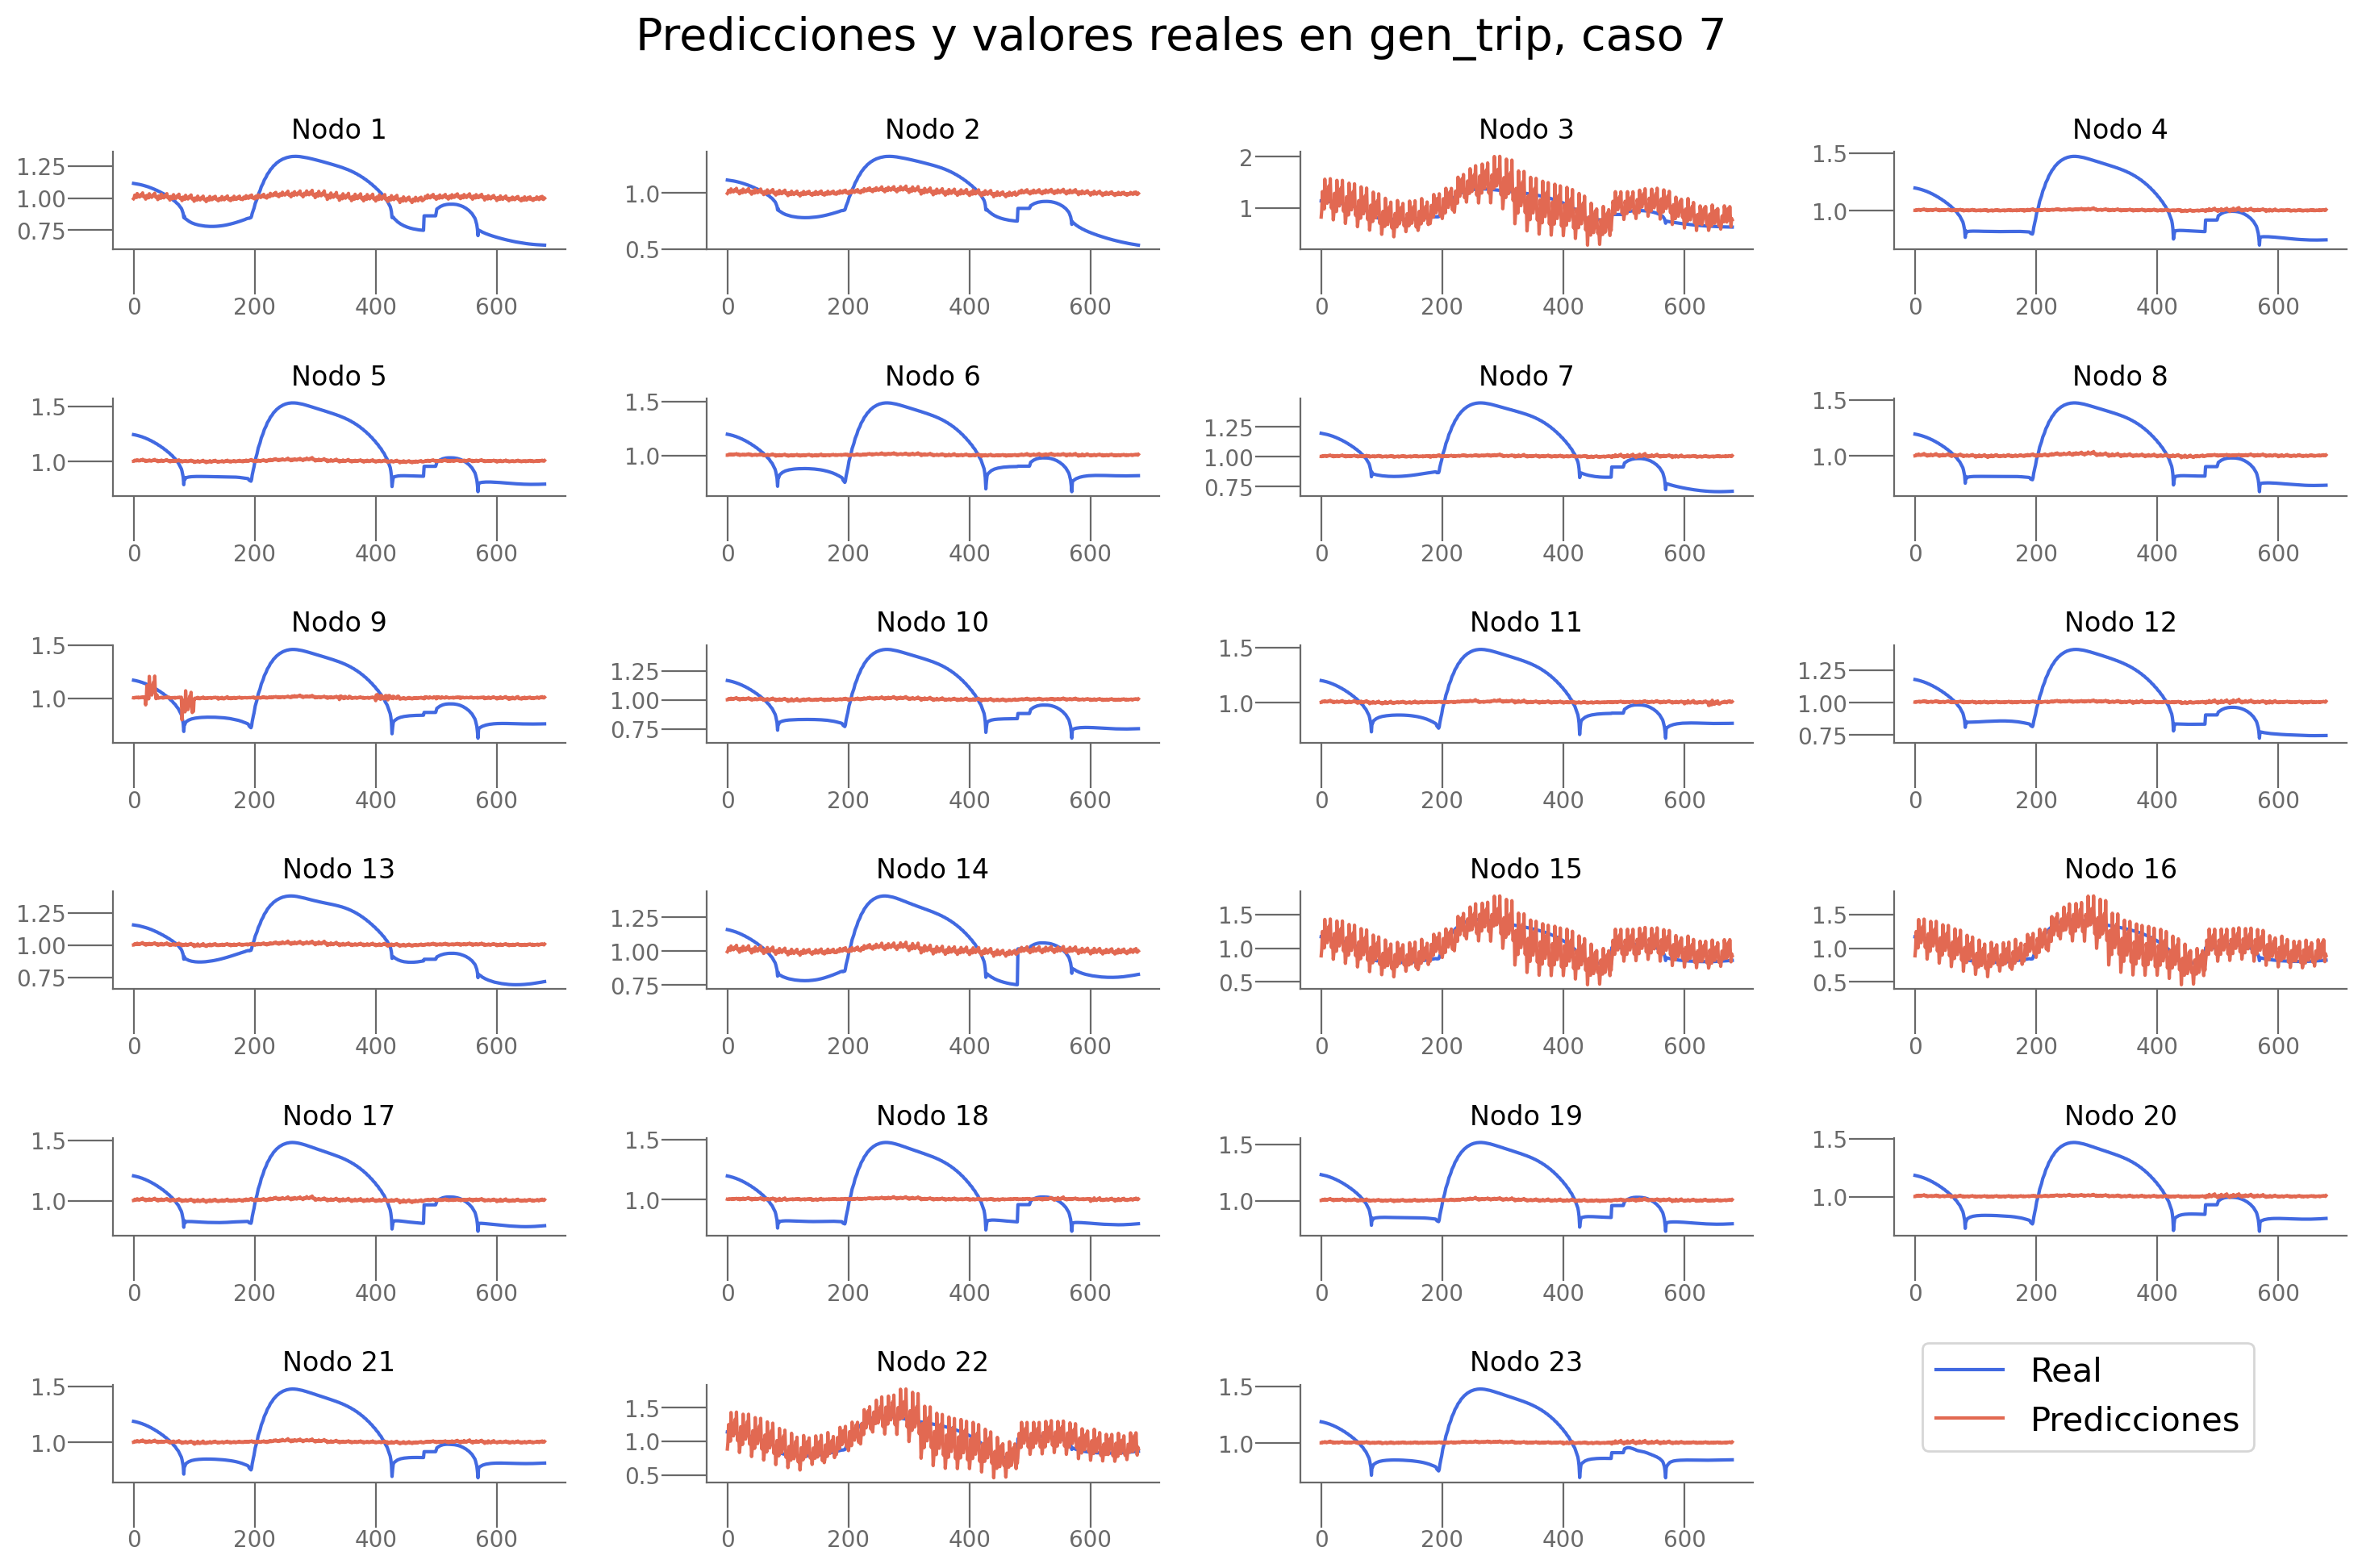

In [32]:
plot_predictions(predictions, real, n_target, 7, n_div_gt, problem_gt)

In [13]:
trainer_gt.save_model()


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1     MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                                NaN   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6     EvolveGCN                                               None   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   
2                                                NaN  0.007437  -1.985579   
3  ./results/gen_trip/ajustes/DryGrEncoder_result...  0.006246  -1.

### Bus trip

In [8]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [9]:
n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 5.0149 | Eval Loss: 1.0178 | Eval R2: -34.6233 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.6814 | Eval Loss: 0.7573 | Eval R2: -24.9420 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.7729 | Eval Loss: 0.7078 | Eval R2: -23.1768 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.1737 | Eval Loss: 0.6575 | Eval R2: -21.3636 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.9055 | Eval Loss: 0.6138 | Eval R2: -19.7655 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.7941 | Eval Loss: 0.5714 | Eval R2: -18.2232 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.7593 | Eval Loss: 0.5360 | Eval R2: -16.8914 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.8024 | Eval Loss: 0.4956 | Eval R2: -15.4379 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.8181 | Eval Loss: 0.4617 | Eval R2: -14.1966 | LR: 0.0010 | 
Epoch 10/100 | Train Loss: 

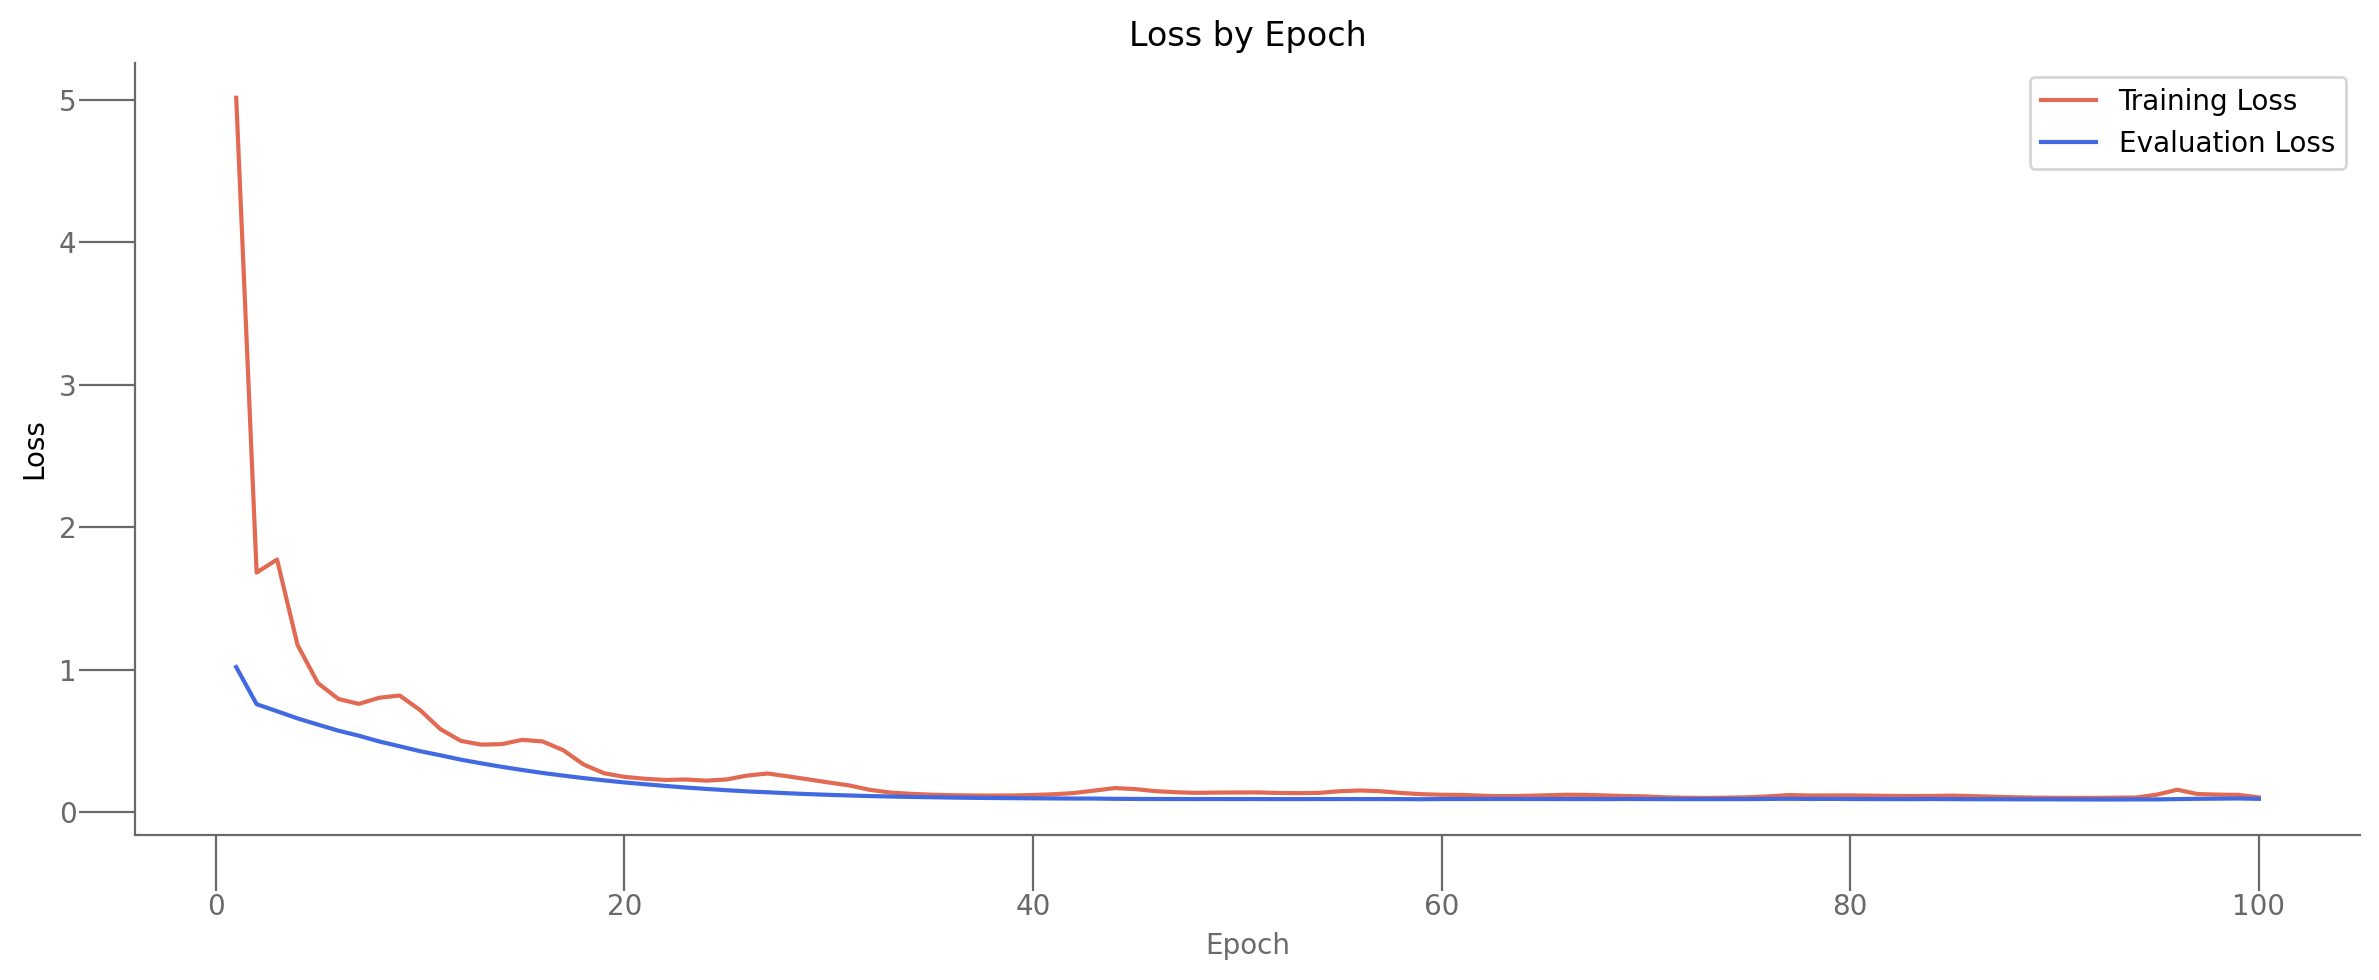


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.093919, test R2 score: -1.197425


In [12]:
model = RecurrentGCN("EvolveGCN",node_features= n_features, node_count=n_nodes, n_target=n_target)


trainer_bt = TrainerEvolveGCN(model, dataset_bt, device, f"./results/{problem_bt}", dataloader_params2)

losses,eval_losses, r2scores = trainer_bt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), len(losses), format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_bt.test()


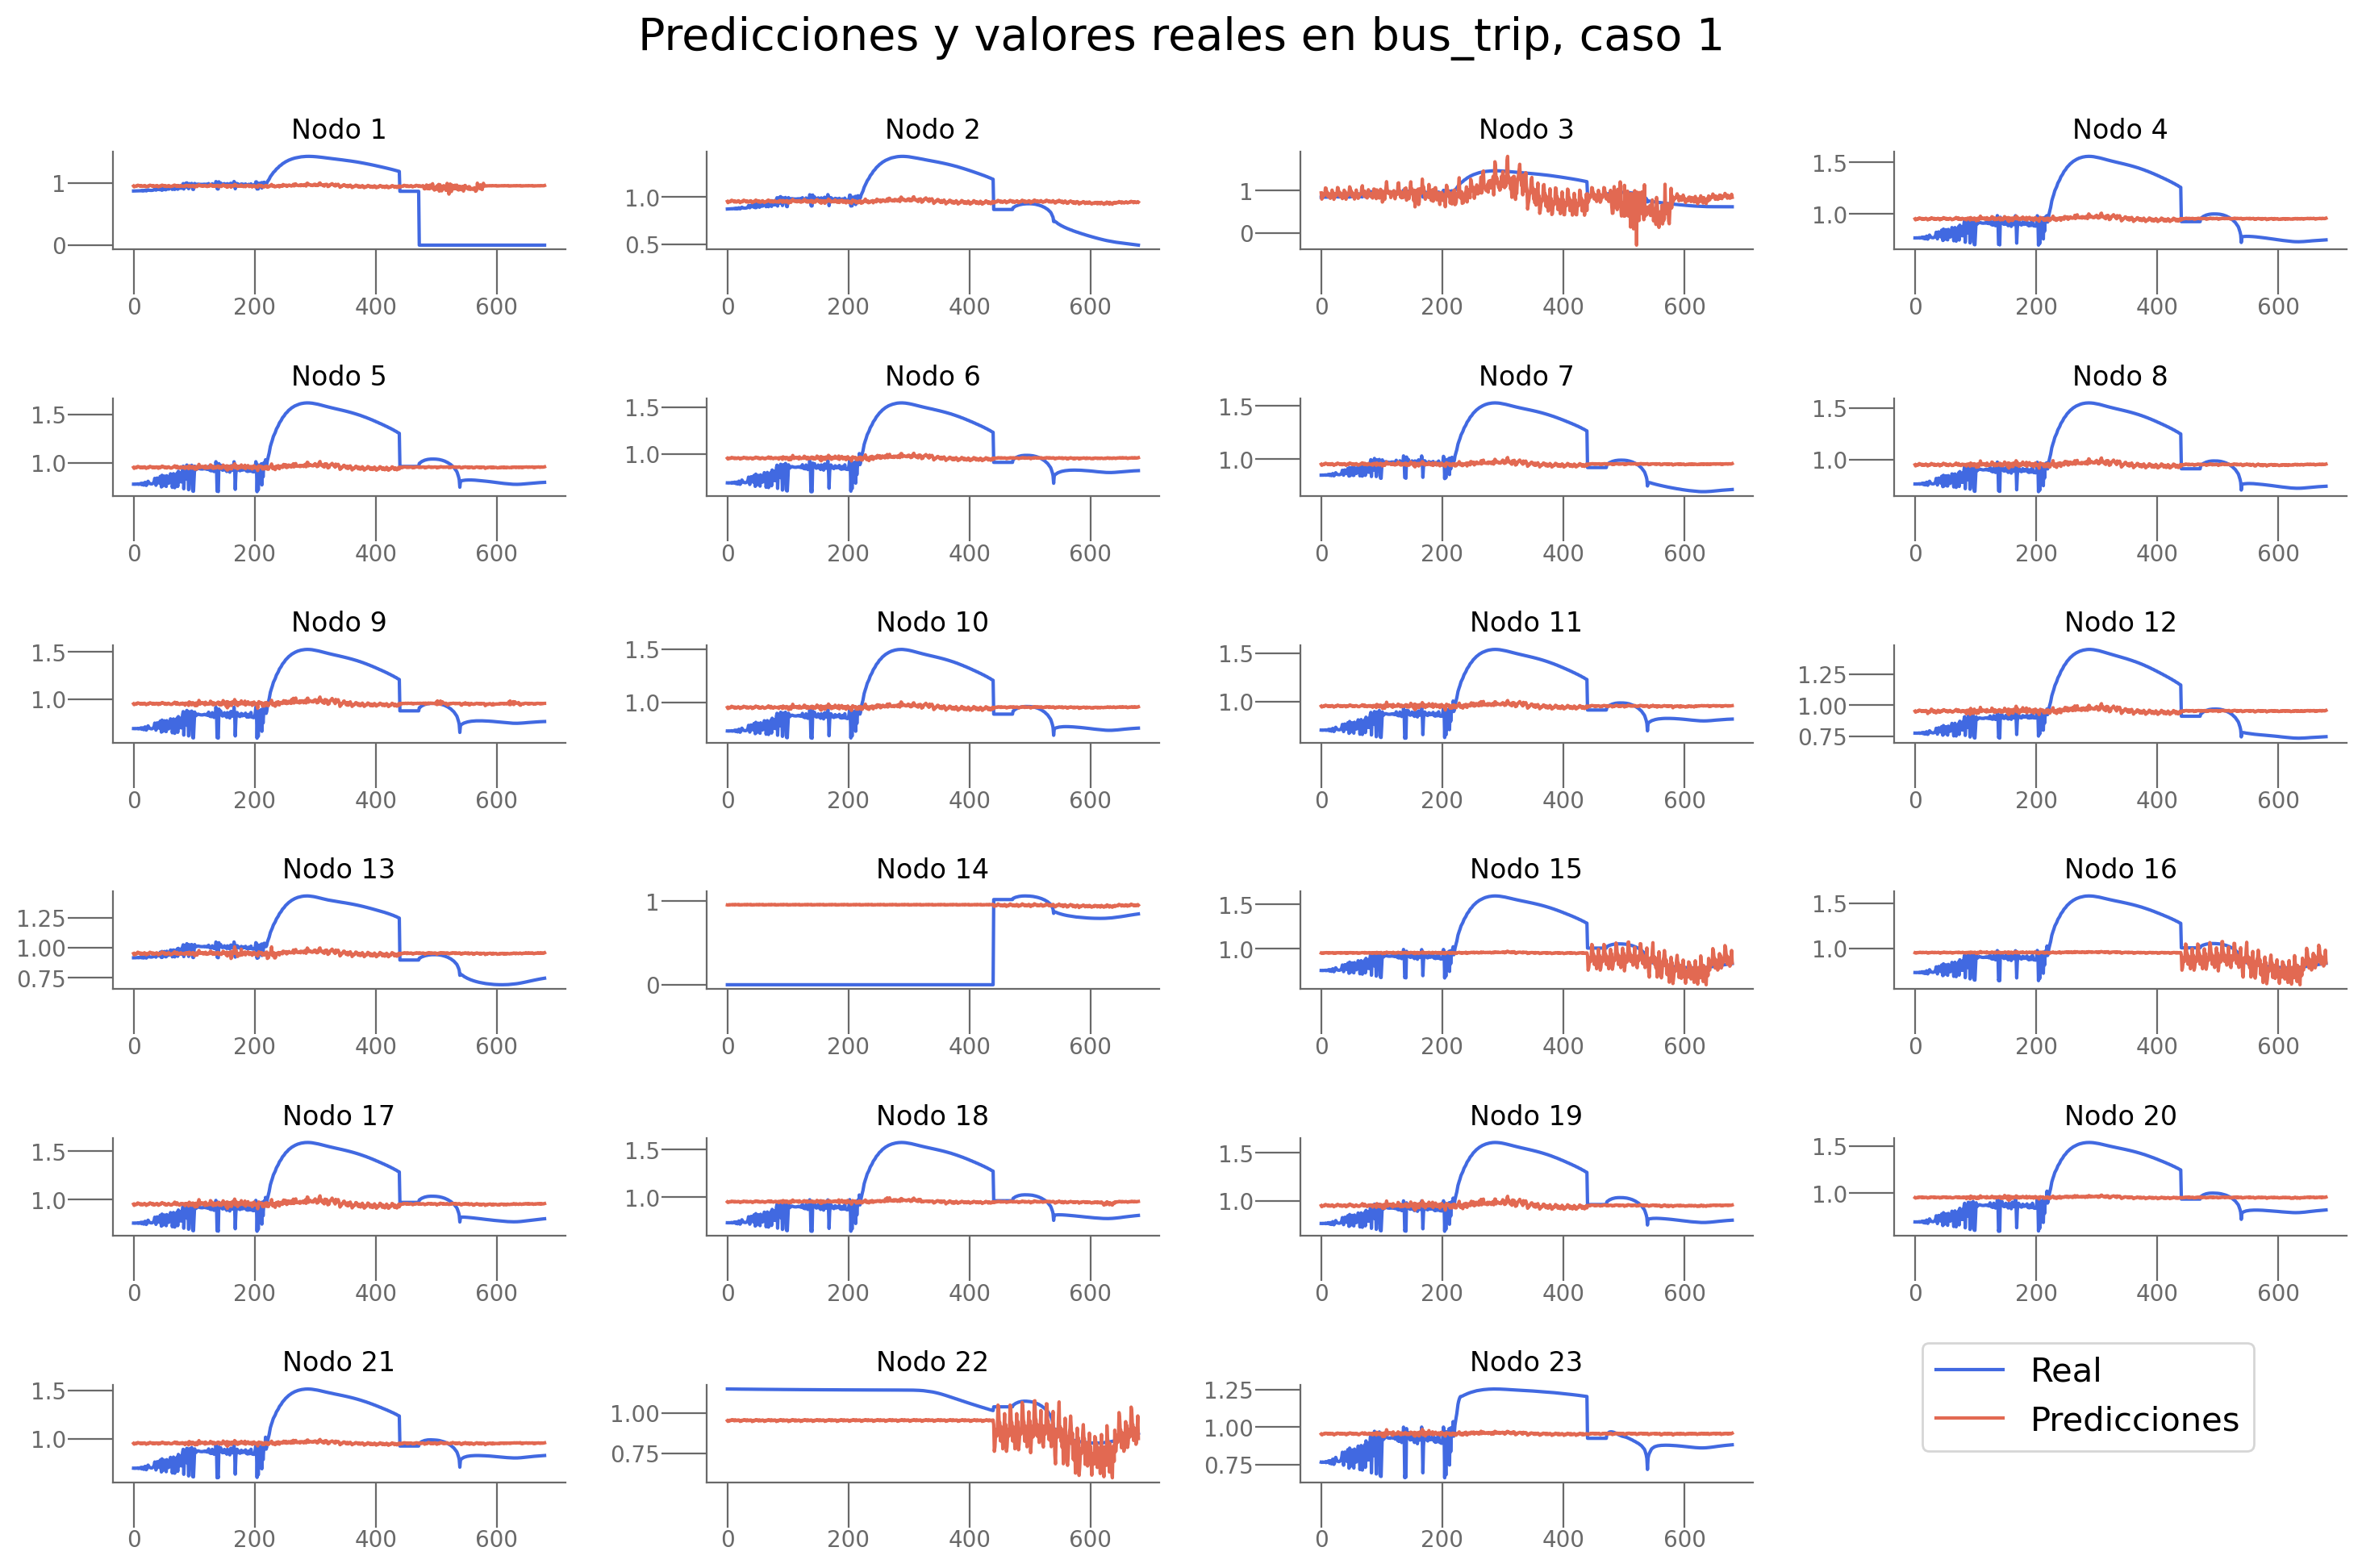

In [13]:
plot_predictions(predictions, real, n_target, 1, n_div_bt, problem_bt)

In [14]:
trainer_bt.save_model()


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                                          (32, 0.8)   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6         DCRNN                                     {'hidden': 60}   
7     EvolveGCN                                               None   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1                                                NaN  0.005606  0.865487   
2    ./results/bus_trip/ajustes/MPNNLSTM_results.csv  0.006753  0.845855   
3

### Bus fault

In [8]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [9]:
n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 3.4155 | Eval Loss: 0.5391 | Eval R2: -157.5933 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.4487 | Eval Loss: 0.4051 | Eval R2: -124.7645 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.3912 | Eval Loss: 0.3782 | Eval R2: -123.1187 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.3643 | Eval Loss: 0.3528 | Eval R2: -119.2781 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.3422 | Eval Loss: 0.3288 | Eval R2: -111.5721 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.3186 | Eval Loss: 0.3048 | Eval R2: -101.0398 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.2958 | Eval Loss: 0.2866 | Eval R2: -96.4876 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.2782 | Eval Loss: 0.2717 | Eval R2: -92.6631 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.2633 | Eval Loss: 0.2573 | Eval R2: -88.1469 | LR: 0.0010 | 
Epoch 10/100 | Train 

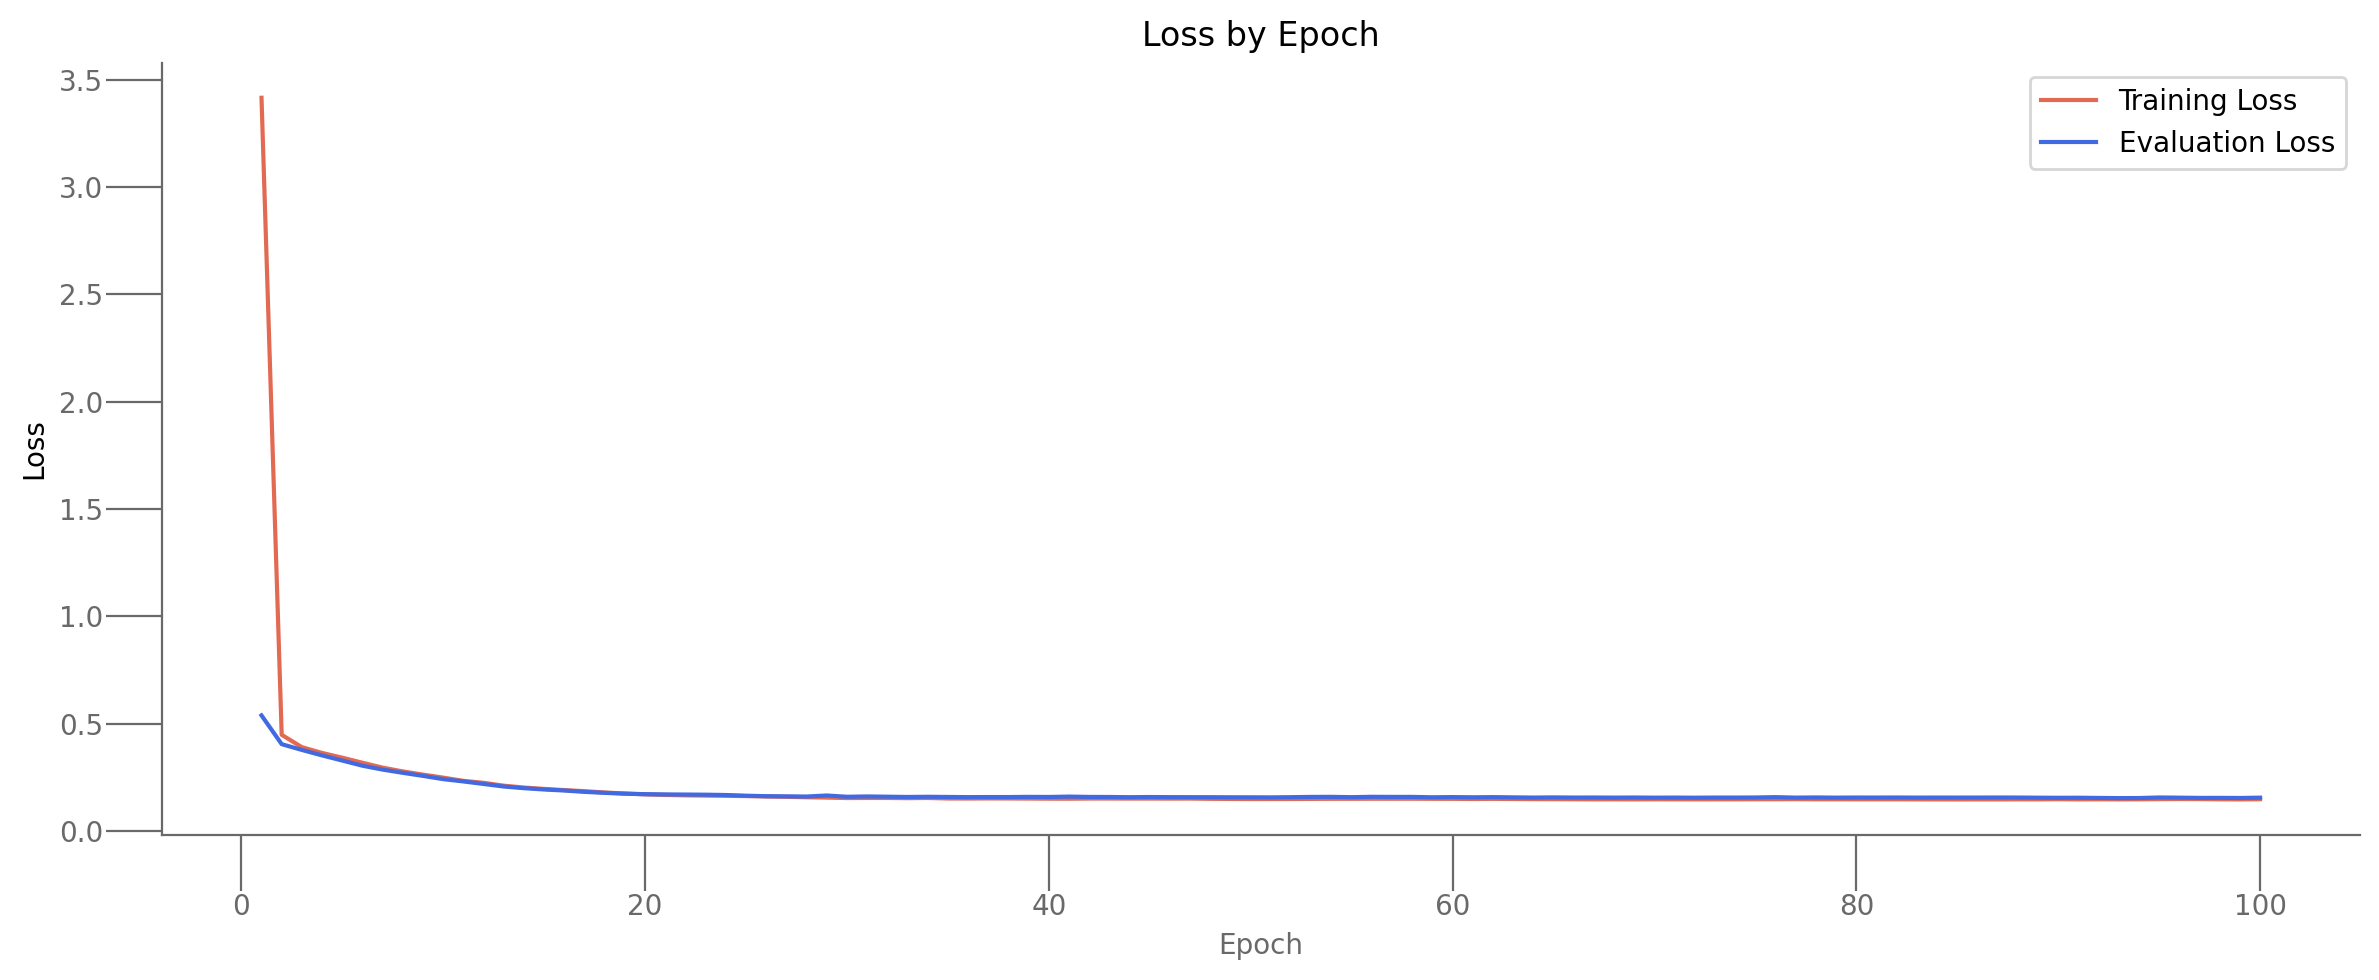


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.119127, test R2 score: -22.320534


In [10]:
model = RecurrentGCN("EvolveGCN",node_features= n_features, node_count=n_nodes, n_target=n_target)


trainer_bf = TrainerEvolveGCN(model, dataset_bf, device, f"./results/{problem_bf}", dataloader_params2)

losses,eval_losses, r2scores = trainer_bf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_bf.test()


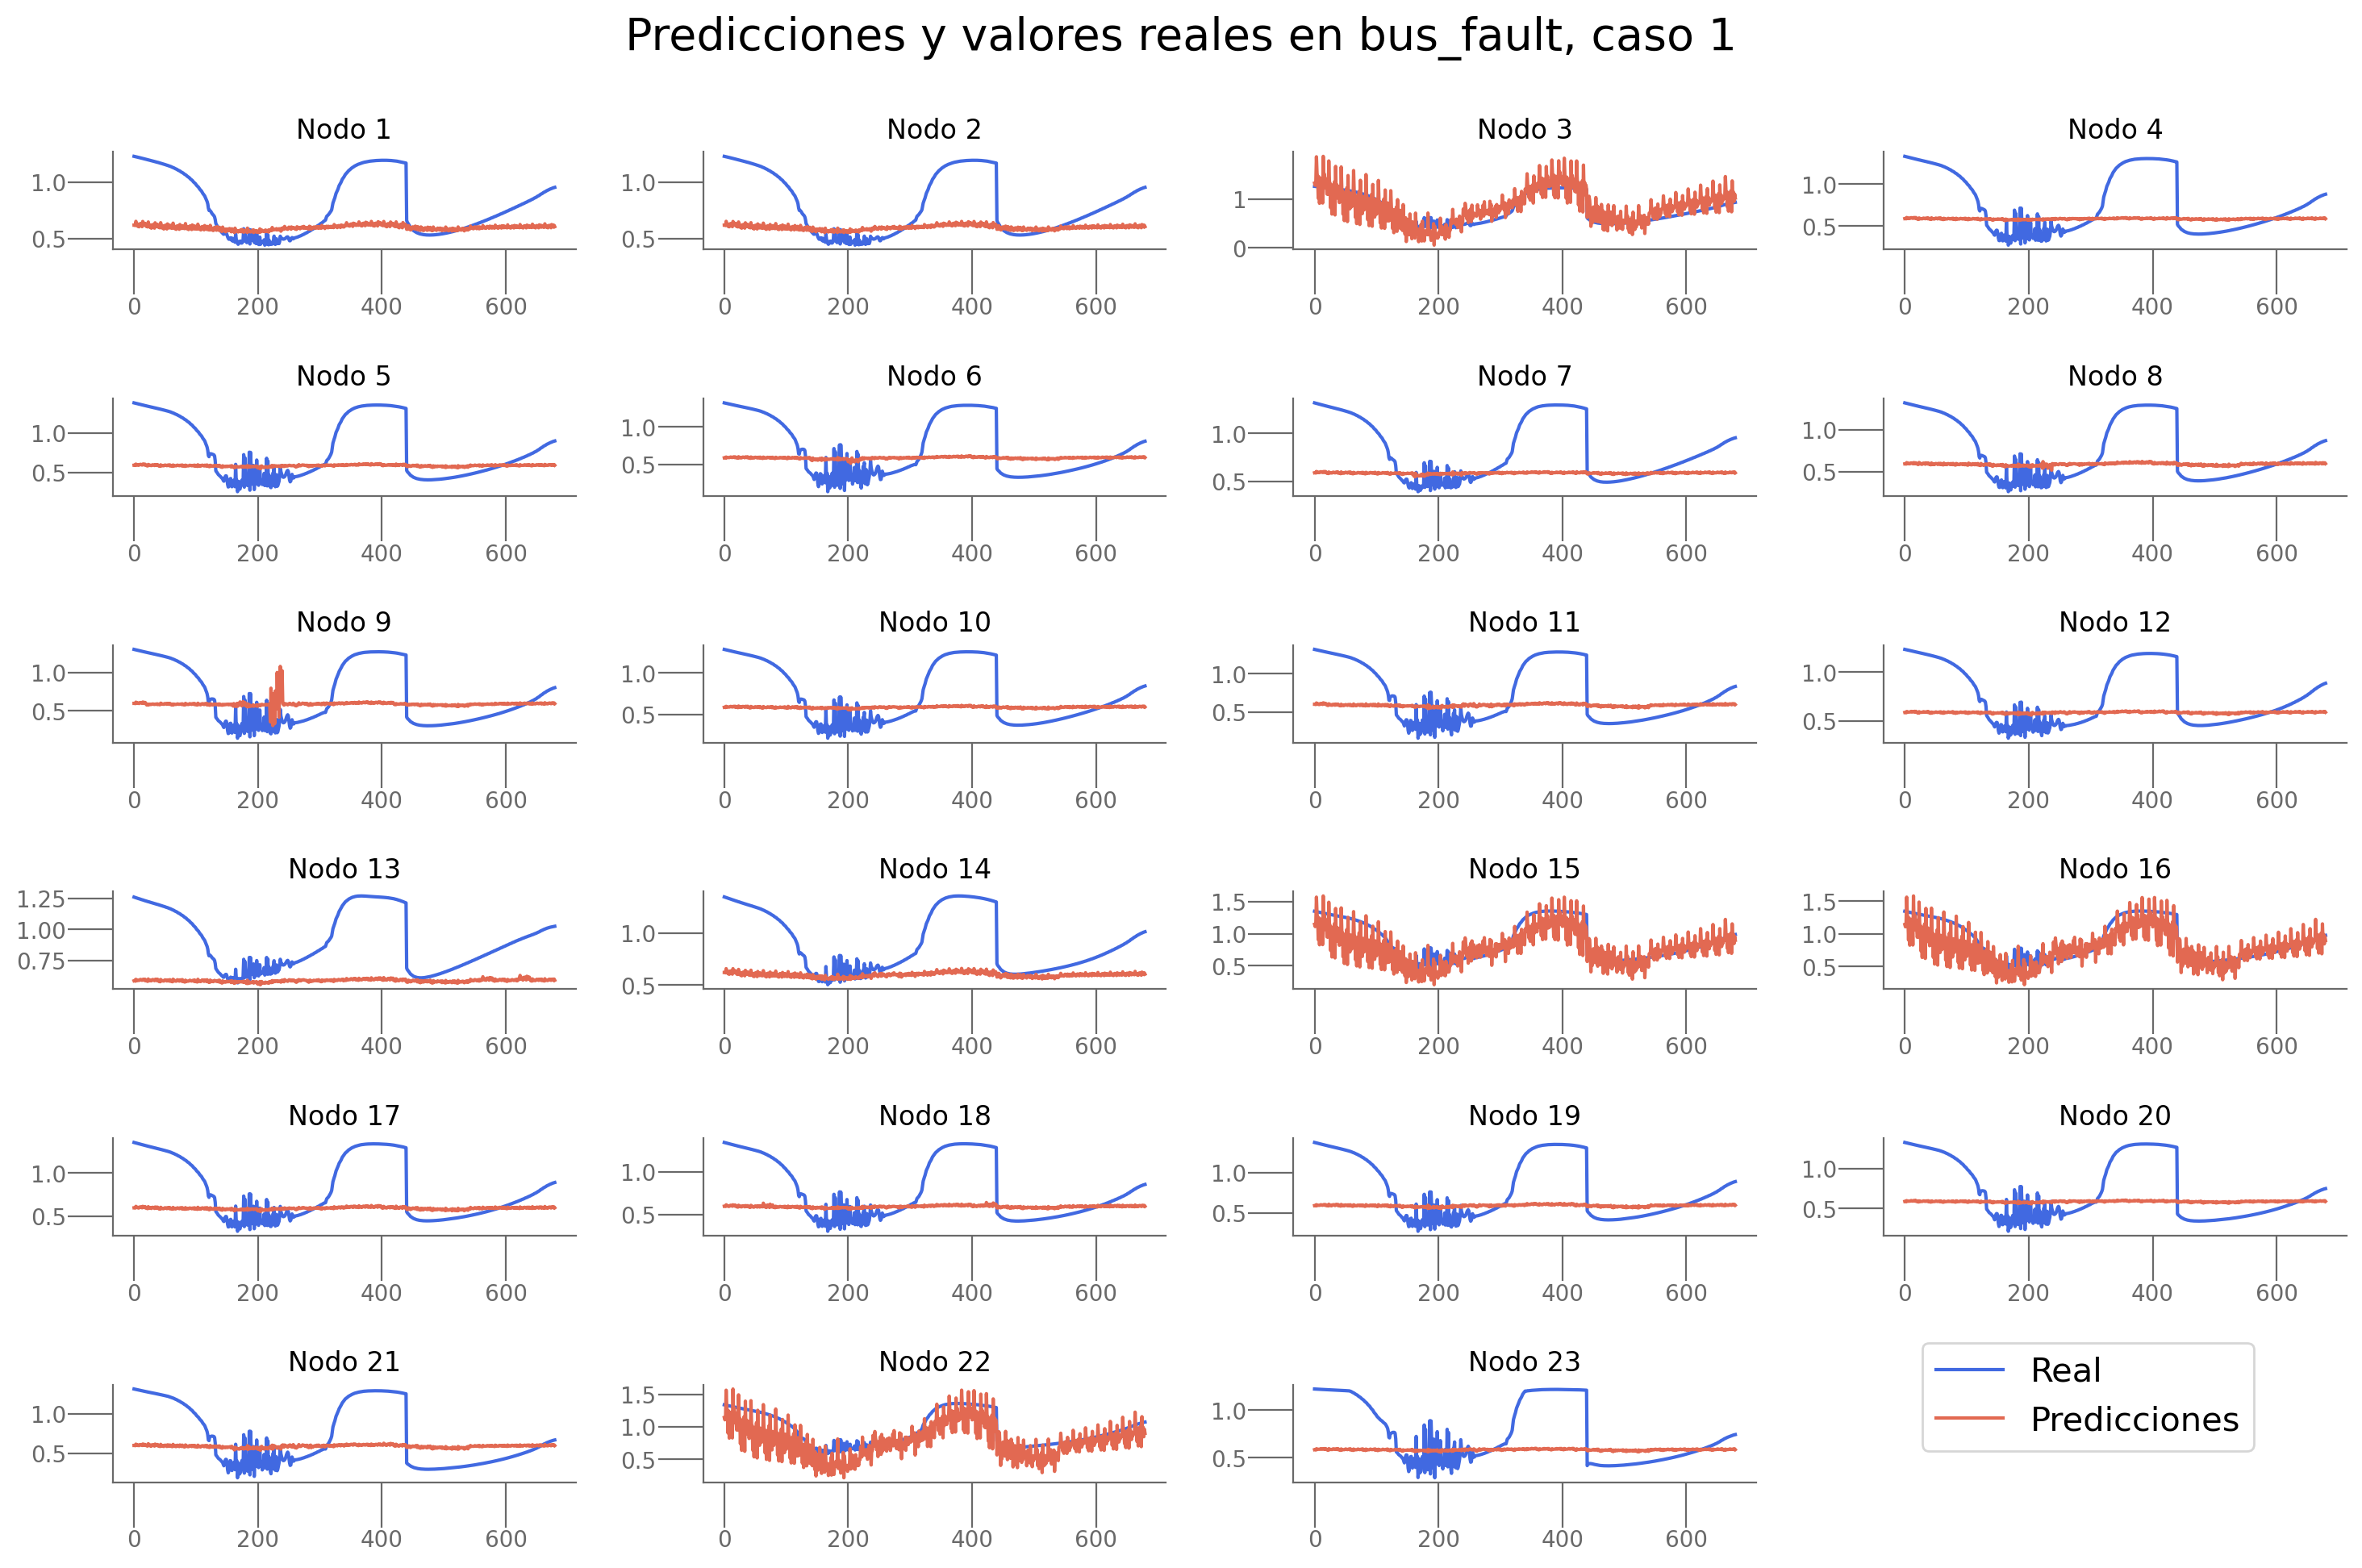

In [11]:
plot_predictions(predictions, real, n_target, 1, n_div_bf, problem_bf)

In [12]:
trainer_bf.save_model()


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder             {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5         DCRNN                                     {'hidden': 40}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
7     EvolveGCN                                               None   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.017298   0.603716   
1                                                NaN  0.017459  -1.122112   
2   ./results/bus_fault/ajustes/MPNNLSTM_results.csv  0.016746  -0.682421 

### Branch Fault

In [13]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [14]:
n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5





==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 4.7251 | Eval Loss: 0.5000 | Eval R2: -58.5404 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.3518 | Eval Loss: 0.4231 | Eval R2: -50.7271 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.3112 | Eval Loss: 0.3922 | Eval R2: -47.6507 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.2857 | Eval Loss: 0.3659 | Eval R2: -44.9490 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.2641 | Eval Loss: 0.3408 | Eval R2: -42.1400 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.2439 | Eval Loss: 0.3188 | Eval R2: -39.6086 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.2271 | Eval Loss: 0.3001 | Eval R2: -37.3331 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.2117 | Eval Loss: 0.2835 | Eval R2: -35.3161 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.1991 | Eval Loss: 0.2688 | Eval R2: -33.4826 | LR: 0.0010 | 
Epoch 10/100 | Train Loss: 

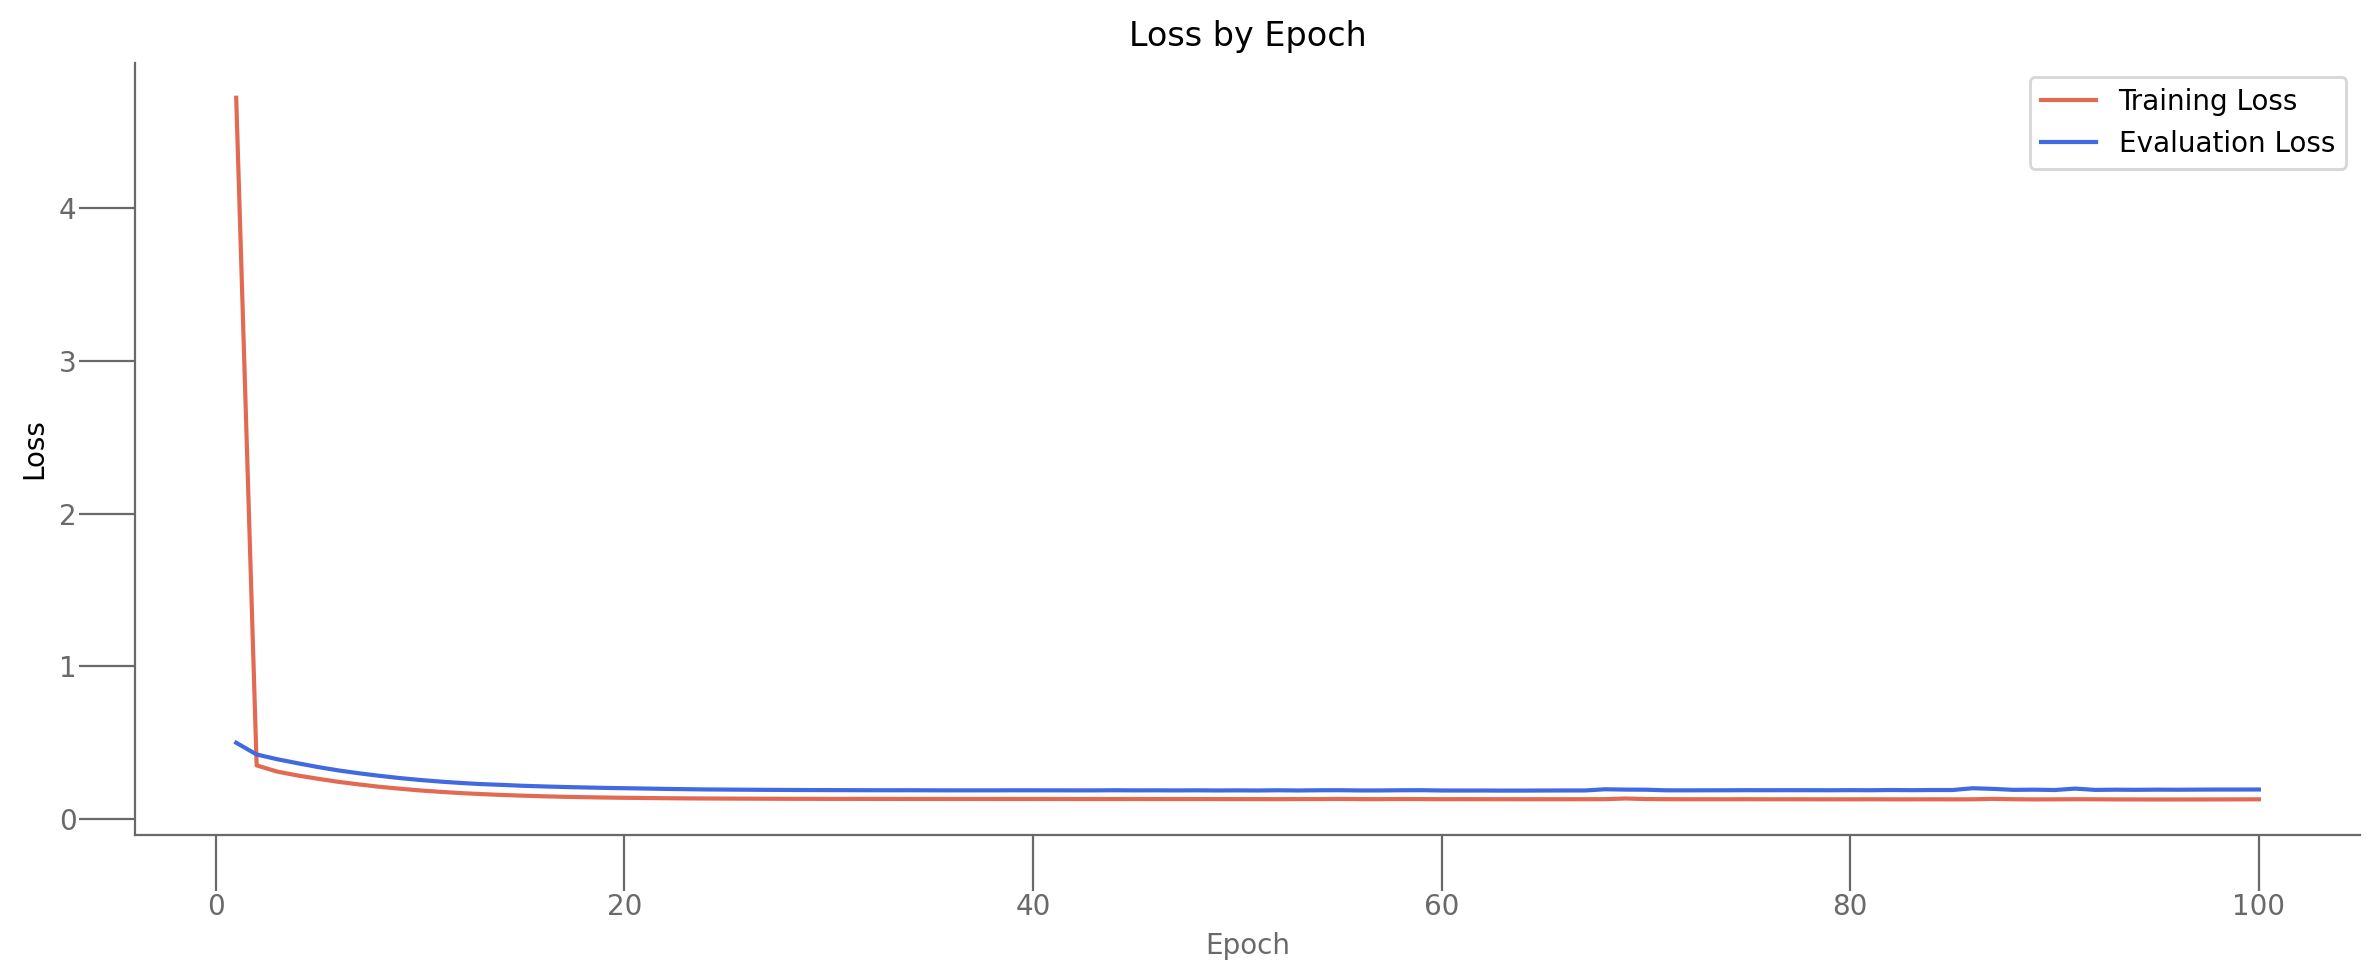


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.111567, test R2 score: -13.382250


In [15]:

model = RecurrentGCN("EvolveGCN",node_features= n_features, node_count=n_nodes, n_target=n_target)


trainer_brf = TrainerEvolveGCN(model, dataset_brf, device, f"./results/{problem_brf}", dataloader_params2)

losses,eval_losses, r2scores = trainer_brf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_brf.test()


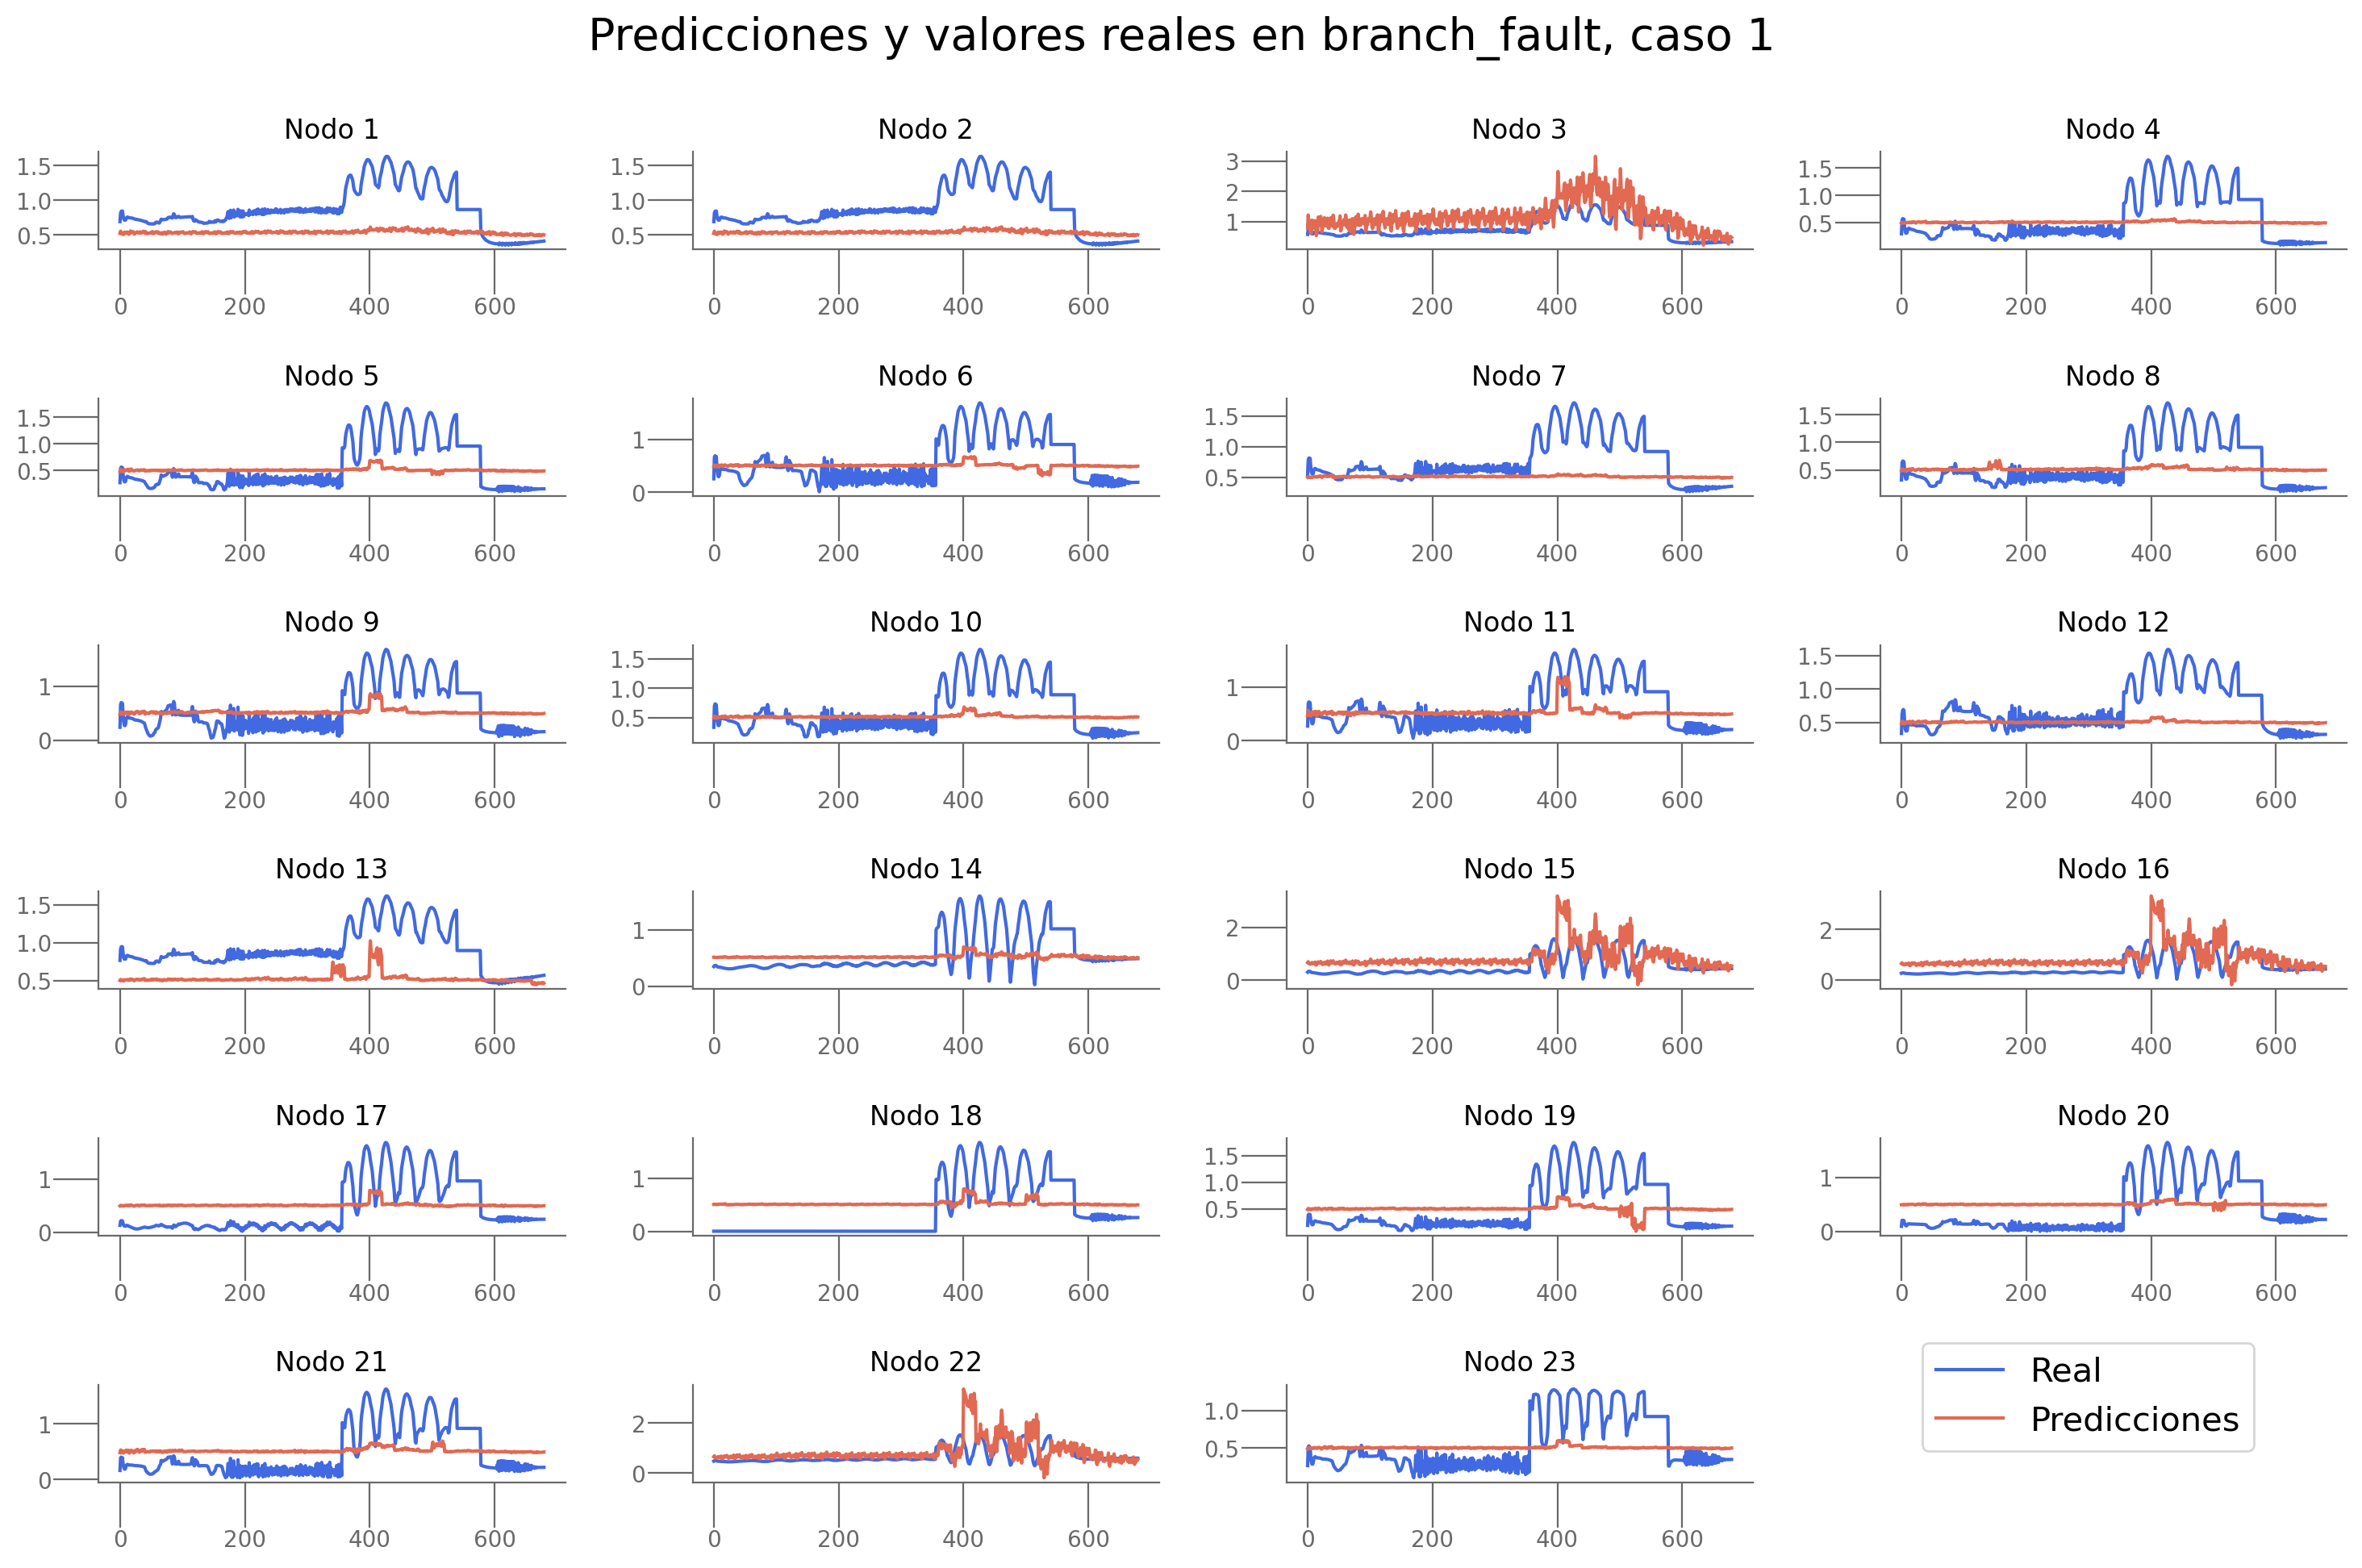

In [16]:
plot_predictions(predictions, real, n_target, 1, n_div_brf, problem_brf)

In [17]:
trainer_brf.save_model()


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5         DCRNN                                     {'hidden': 60}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
7     EvolveGCN                                               None   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.023216   0.608045   
1                                                NaN  0.021628  -1.528487   
2  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.020580  -1.669938 

### Branch trip

In [18]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [19]:
n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5





==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 7.3206 | Eval Loss: 0.8815 | Eval R2: -749.3055 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.7926 | Eval Loss: 0.7470 | Eval R2: -635.4124 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.7205 | Eval Loss: 0.6893 | Eval R2: -587.5329 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.6652 | Eval Loss: 0.6340 | Eval R2: -541.2050 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.6130 | Eval Loss: 0.5816 | Eval R2: -497.2116 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.5582 | Eval Loss: 0.5330 | Eval R2: -456.3259 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.5049 | Eval Loss: 0.4877 | Eval R2: -418.1004 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.4609 | Eval Loss: 0.4453 | Eval R2: -382.3094 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.4227 | Eval Loss: 0.4060 | Eval R2: -348.9293 | LR: 0.0010 | 
Epoch 10/100 | Tra

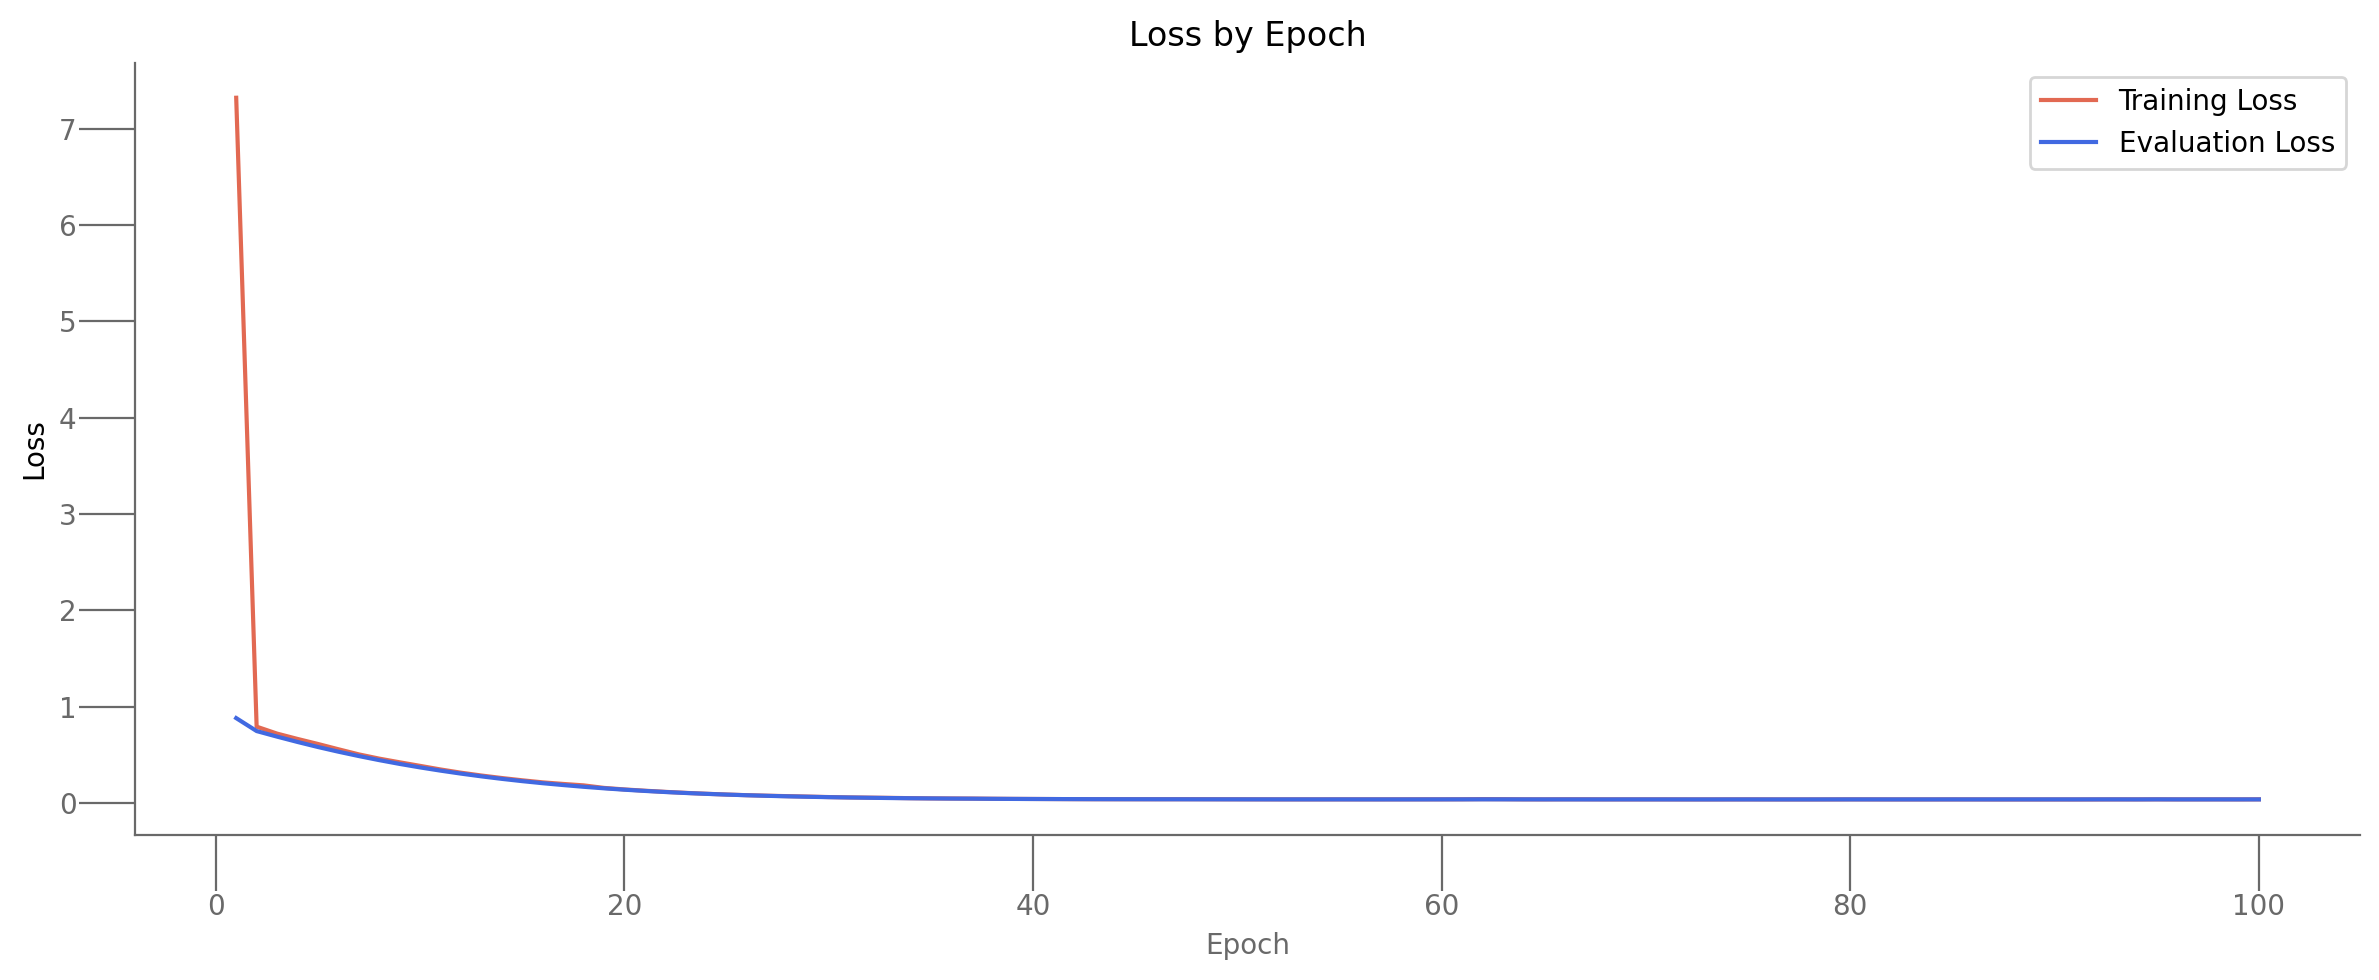


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.043728, test R2 score: -20.675121


In [20]:

model = RecurrentGCN("EvolveGCN",node_features= n_features, node_count=n_nodes, n_target=n_target)


trainer_brt = TrainerEvolveGCN(model, dataset_brt, device, f"./results/{problem_brt}", dataloader_params2)

losses,eval_losses, r2scores = trainer_brt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_brt.test()


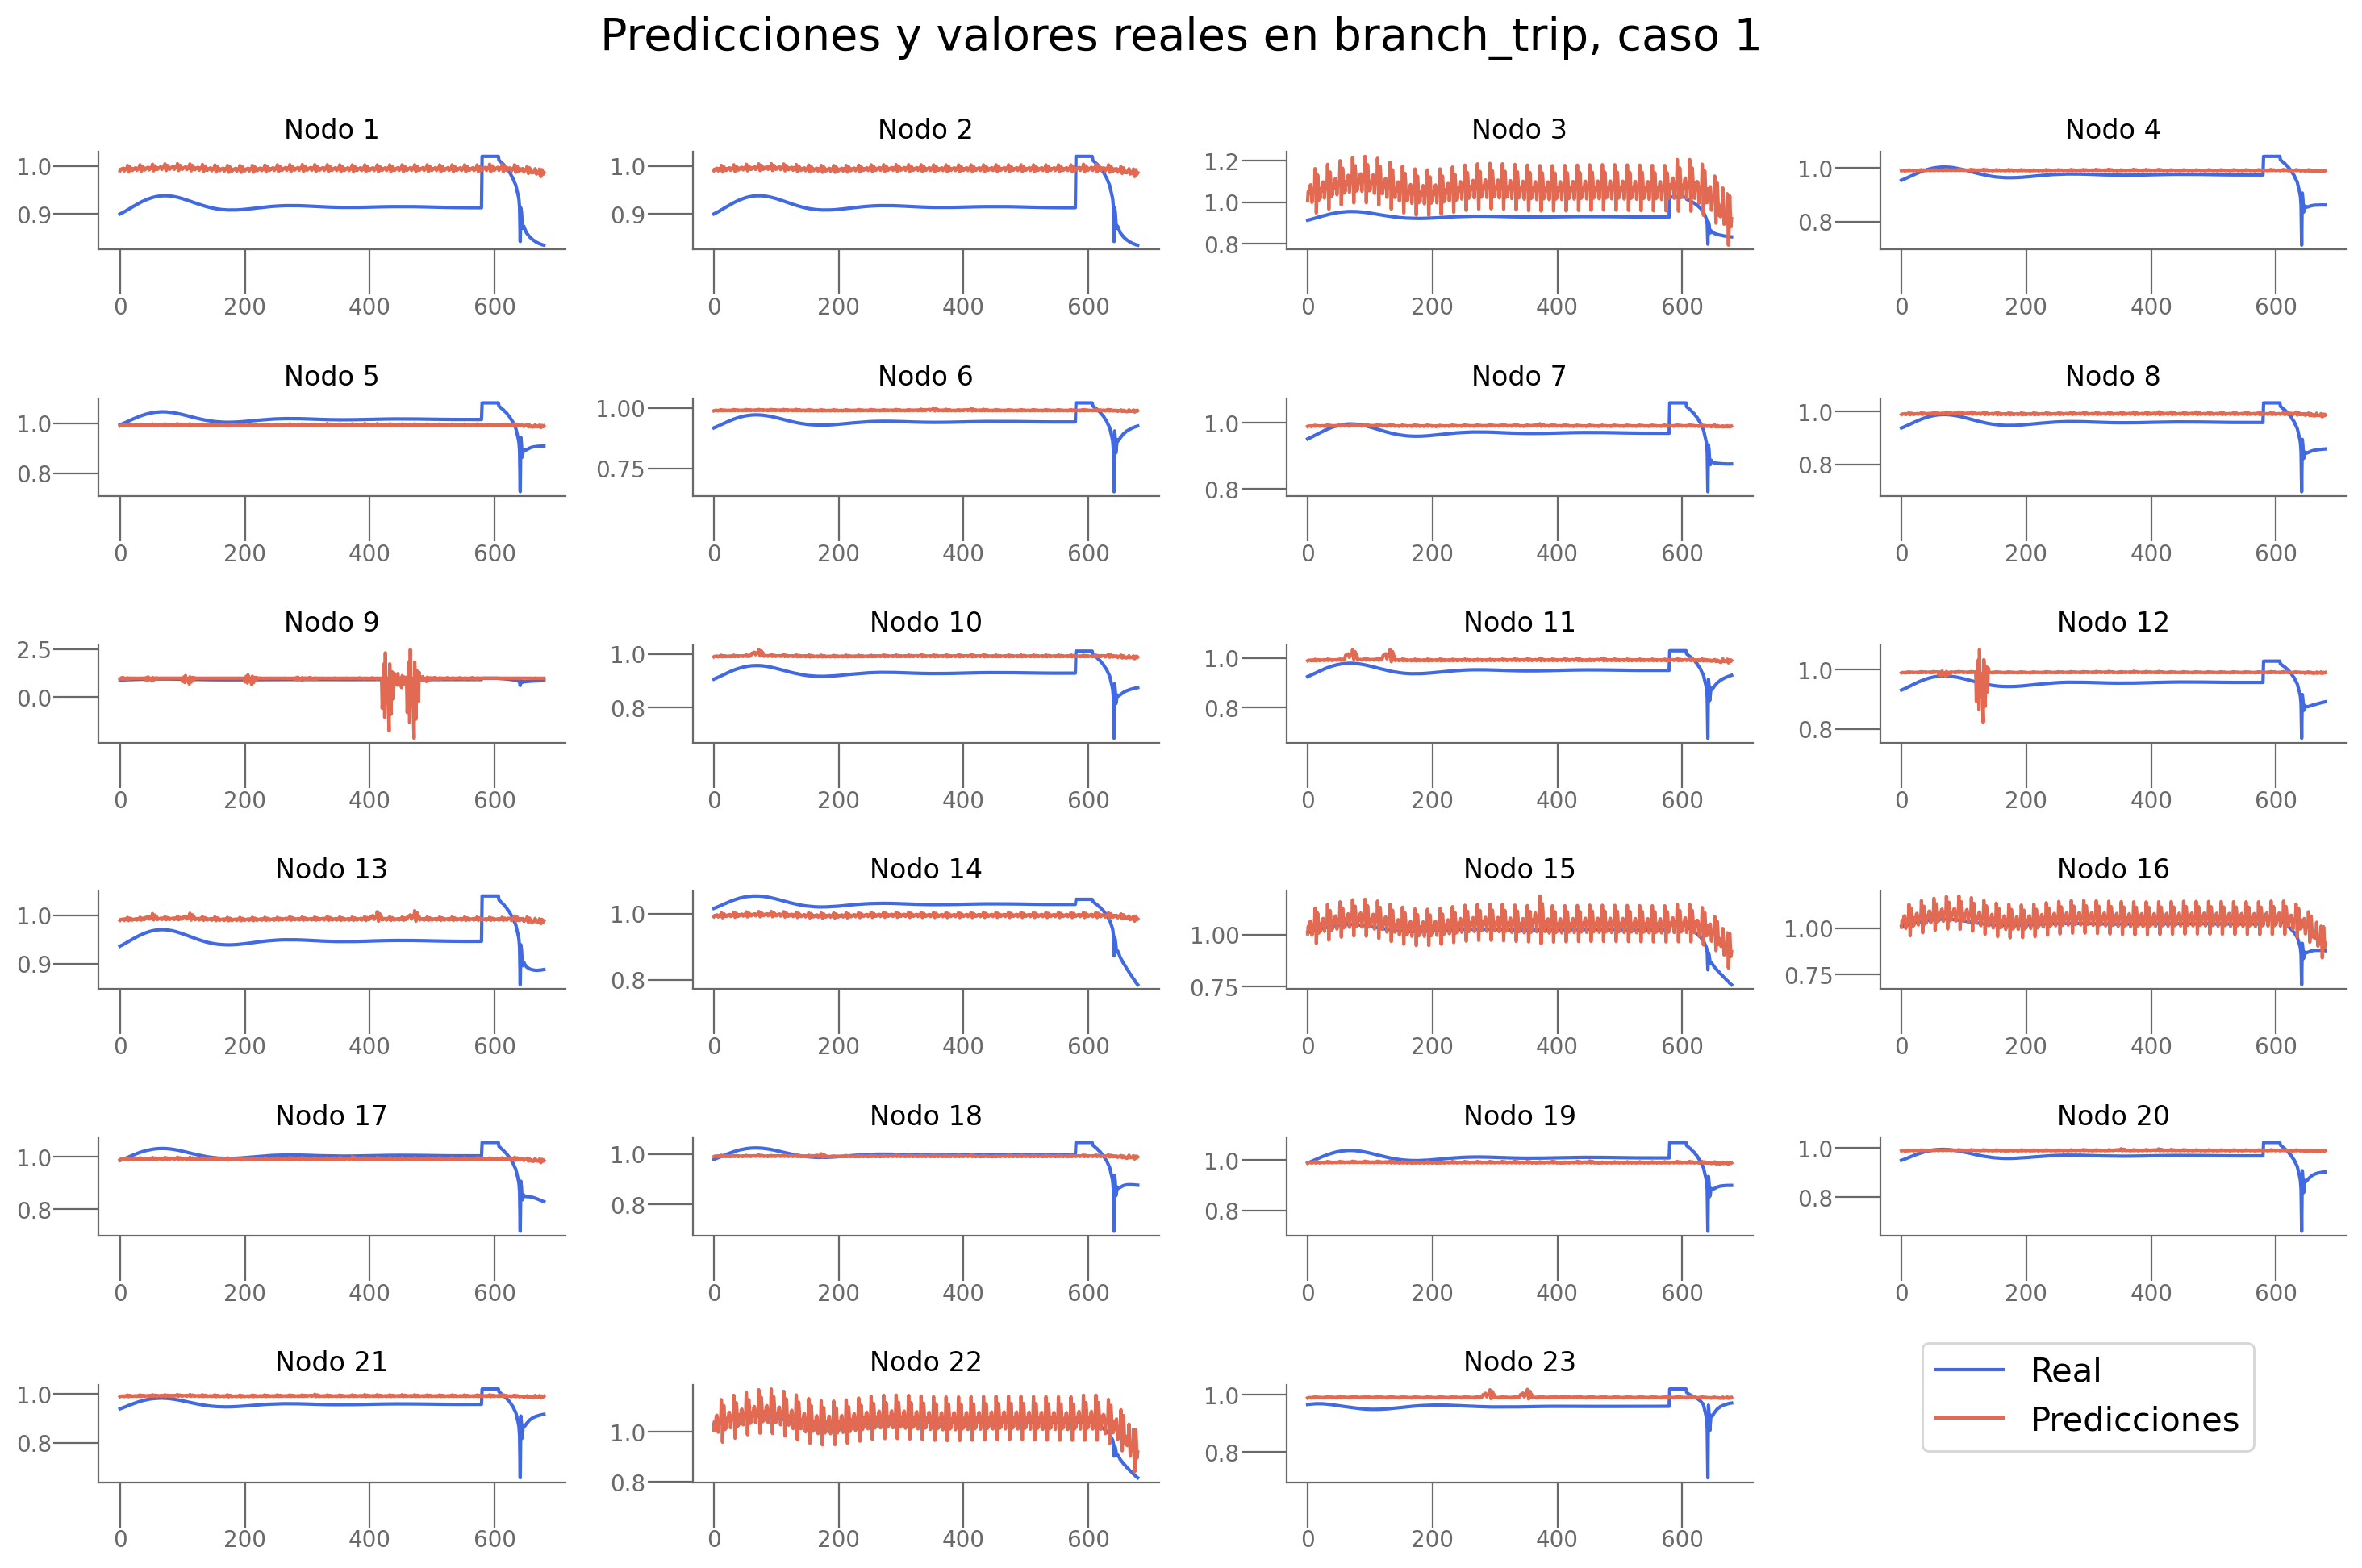

In [21]:
plot_predictions(predictions, real, n_target, 1, n_div_brt, problem_brt)

In [22]:
trainer_brt.save_model()


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM                {'hidden_size': 32, 'dropout': 0.8}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5         DCRNN                                     {'hidden': 60}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
7        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
8     EvolveGCN                                               None   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.003700   0.398922   
1                                                NaN  0.004787  -1.839737   
2  .